In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.dataset_alt import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms as T
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model_alt_2 import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Custom Transforms imports:
from custom_transforms import *

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# SKLearn imports:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Other imports:
from tqdm import tqdm

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda', index=0)

In [5]:
torch.backends.cudnn.benchmark = True

# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [6]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [7]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.

# Creating the sharpness transform:
sharpen = Sharpen(sharpness_factor=2.5)

original_image_dim = (450, 600)

# Defining the new image dimension:
resize_fraction = 1.75

new_height = int(original_image_dim[0] * resize_fraction)
new_width = int(original_image_dim[1] * resize_fraction)
image_dim = (new_height, new_width)

image_preprocessing = T.Compose([
                            T.ToTensor(),
                            T.transforms.Normalize(mean, std),
                            T.Resize(image_dim),
                            sharpen])

# Defining the dataset:

In [8]:
# Creating the dataset instance:
test_dataset = SkinDataset(transforms=image_preprocessing)

### The dataset class distribution:

In [9]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

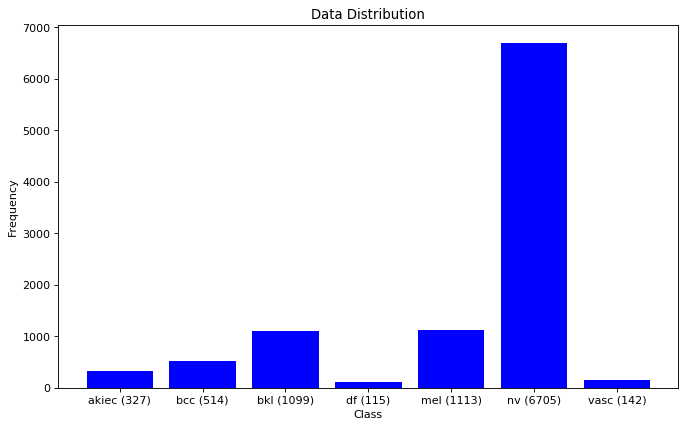

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [11]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

selected_class = 0
sample_array_3 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2 + sample_array_3

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [12]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32, num_workers=8)

### Creating the model:

In [13]:
model_overfit = Model(num_classes=7, image_dim=image_dim, dropout_prob=[0,0,0])

### The hyperparameters, the loss function and the optimizer:

In [14]:
learning_rate = 6e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=learning_rate)

In [15]:
epochs = 25

### Overfitting the model:

In [16]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/25 [00:03<?, ?it/s]


KeyboardInterrupt: 

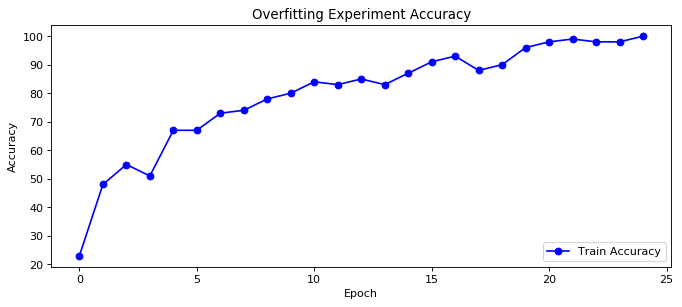

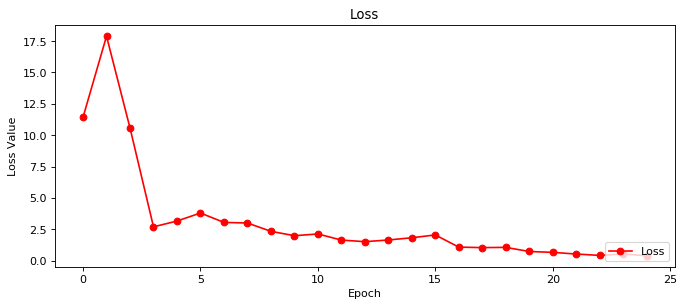

In [17]:
# --- Accuracy: ------------------------------------------------

figure(figsize=(10, 4), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.legend(["Train Accuracy"], loc ="lower right")
plt.show()

# --- Loss: ----------------------------------------------------

figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'ro-')
plt.legend(["Loss"], loc ="lower right")
plt.show()

# =============================================================

# Setting up the actual model:

### Defining the Dataset object:

In [8]:
dataset = SkinDataset()

### Splitting the dataset into train, validation, and test sets:

In [9]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.7
validation_proportion = 0.15
test_proportion = 0.15

# Defining all possible indecies to create a dataset with:
all_indecies = np.arange(len(dataset))

# --- Undersample the class with the most images: -----------------------------
# This process consists of:
# 1) Finding the class that has the most images.
# 2) Undersampling this class so that it has images that are equal to the average
#     number of images other classes have.

# Getting the data distribution in order to know which class has the most images:
data_dist = dataset.get_data_distribution()
max_value = max(list(data_dist.values()))
max_class = dict(zip(data_dist.values(), data_dist.keys()))[max_value]

# Getting the indecies of the images that correspond to the class with most images:
class_indecies = dataset.get_class_indecies(max_class)

# Determining how many images to keep in this class:
# amount_to_keep = np.mean(list(data_dist.values())).astype(np.int)

# Determining which and how many images to delete:
# to_remove = np.random.choice(class_indecies, len(class_indecies) - amount_to_keep, replace=False)
# inds_to_delete = [i for i, ind in enumerate(np.isin(all_indecies, to_remove)) if ind]

# Deleting those images by removing their indecies from the all possible indecies:
# all_indecies = np.delete(all_indecies, inds_to_delete)

# --- Defining the sizes of the splits: ----------------------------------------------

# 1) The train set size:
train_size = math.ceil(train_proportion * len(all_indecies))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(all_indecies))

# 3) The test set size:
test_size = math.floor(test_proportion * len(all_indecies))

np.random.shuffle(all_indecies)

# --- Defining the indecies for each split: ------------------------------------------
train_set_ind = all_indecies[0: train_size]
val_set_ind = all_indecies[train_size : train_size + validation_size]
test_set_ind = all_indecies[train_size + validation_size : train_size + validation_size + test_size]

# --- Defining the train, validation, and test sets: ---------------------------------
train_set = SkinDataset(indecies=train_set_ind)
validation_set = SkinDataset(transforms=image_preprocessing, indecies=val_set_ind)
test_set = SkinDataset(transforms=image_preprocessing, indecies=test_set_ind)

### Saving the test set so it can be used again for evaluation:

In [10]:
# Defining the path where the test indecies will be saved:
save_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'test_split_indecies_2.txt')

with open(save_path, 'w') as file:
    test_dict = {'test_indecies' : str(list(test_set_ind))}
    json_dump = json.dumps(test_dict)
    file.write(json_dump)

## Plotting the train data distribution before augmentation of all the splits

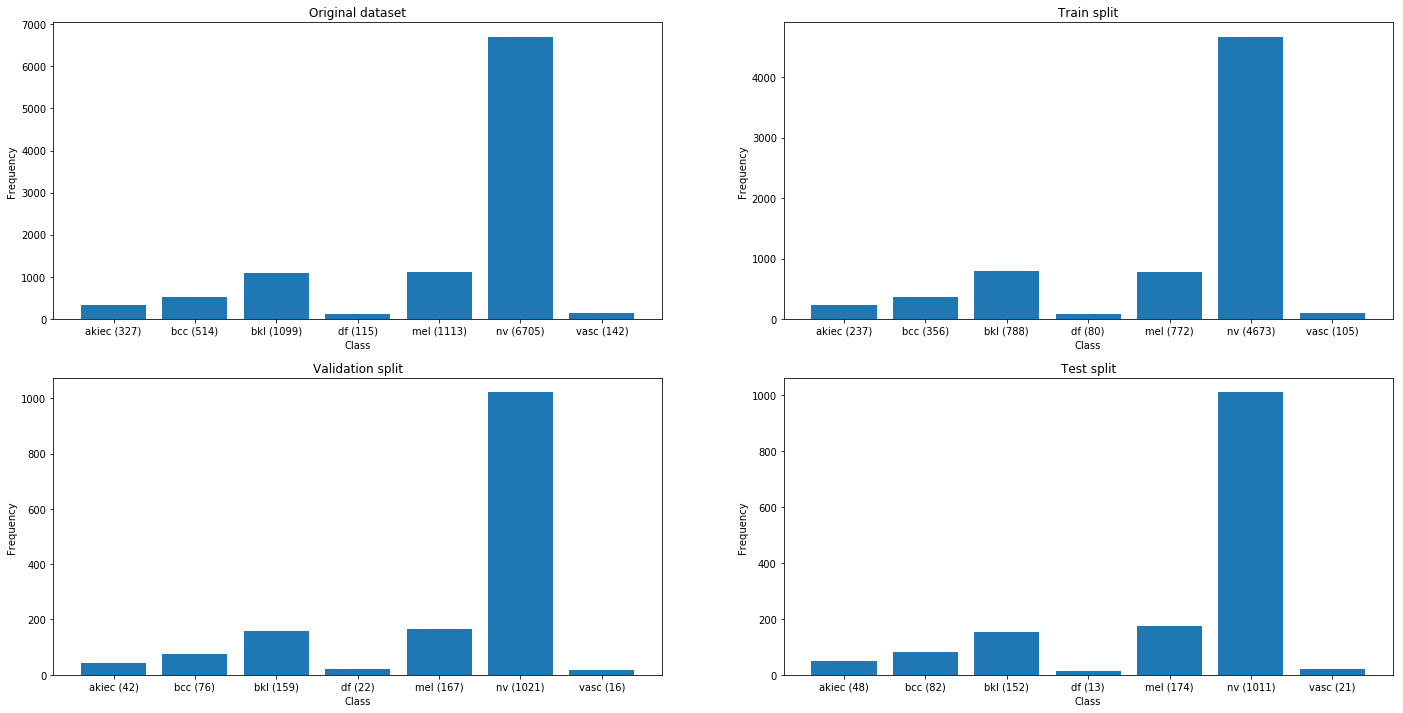

In [11]:
fig, axarr = plt.subplots(2, 2)

fig_size = 12

fig.set_figwidth(fig_size * 2)
fig.set_figheight(fig_size)

titles = ['Original dataset', 'Train split', 'Validation split', 'Test split']
splits = [dataset, train_set, validation_set, test_set]

for ax, split, title in zip(axarr.flatten(), splits, titles):
    data_dist = split.get_data_distribution()
    
    y = list(data_dist.values())
    x = [f'{label} ({count})' for label, count in data_dist.items()]
    
    ax.set_title(title)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.bar(x, y)
    

# Visualizing the preprocessed and the original data:

In [12]:
train_original = SkinDataset(indecies=train_set_ind)
train_preprocessed = SkinDataset(transforms=image_preprocessing, indecies=train_set_ind)

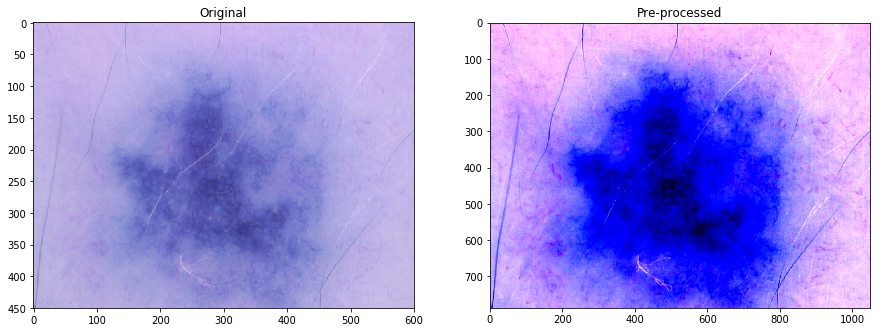

In [13]:
fig, axarr = plt.subplots(1,2)

fig.set_figheight(15)
fig.set_figwidth(15)

index = random.randint(0, len(train_original))

# Retrieving the images:
original_image = train_original[index][0]
preprocessed_image = train_preprocessed[index][0]

# Converting the images to numpy arrays so they can be plotted by matplotlib:
original_image = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
preprocessed_image = np.transpose(preprocessed_image.cpu().detach().numpy(), (1, 2, 0))

axarr[0].set_title('Original')
axarr[1].set_title('Pre-processed')

axarr[0].imshow(original_image)
axarr[1].imshow(preprocessed_image)

# Augmenting the training data:

### Finding the number of data to be augmented for each class:

In [14]:
augmentation_amount = train_set.find_balancing_aug_amount()
augmentation_amount

{'akiec': 4436,
 'bcc': 4317,
 'bkl': 3885,
 'df': 4593,
 'mel': 3901,
 'nv': 0,
 'vasc': 4568}

### Creating a new dataset object with augmeted images:

In [15]:
train_set = SkinDataset(transforms=image_preprocessing, indecies=train_set_ind,
                        augment=True, aug_amount=augmentation_amount)

### Showing the new data distribution:

In [16]:
data_dist = train_set.get_data_distribution()
data_dist

{'akiec': 4673,
 'bcc': 4673,
 'bkl': 4673,
 'df': 4673,
 'mel': 4673,
 'nv': 4673,
 'vasc': 4673}

### The size of the dataset after augmetation:

In [17]:
len(train_set)

32711

# Plotting the data distribution after the augmentation:

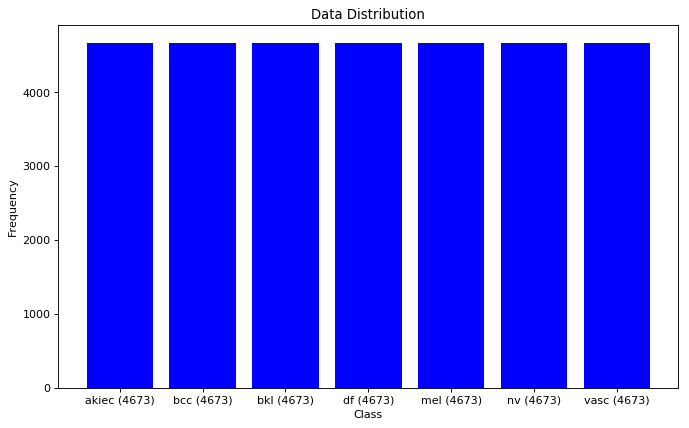

In [18]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Visualizing the a random subset of the train images after augmentation:

### Getting the sample:

In [19]:
sample_size = 16
index_subsample = np.random.choice(np.arange(train_size), sample_size)

### Plotting the images:

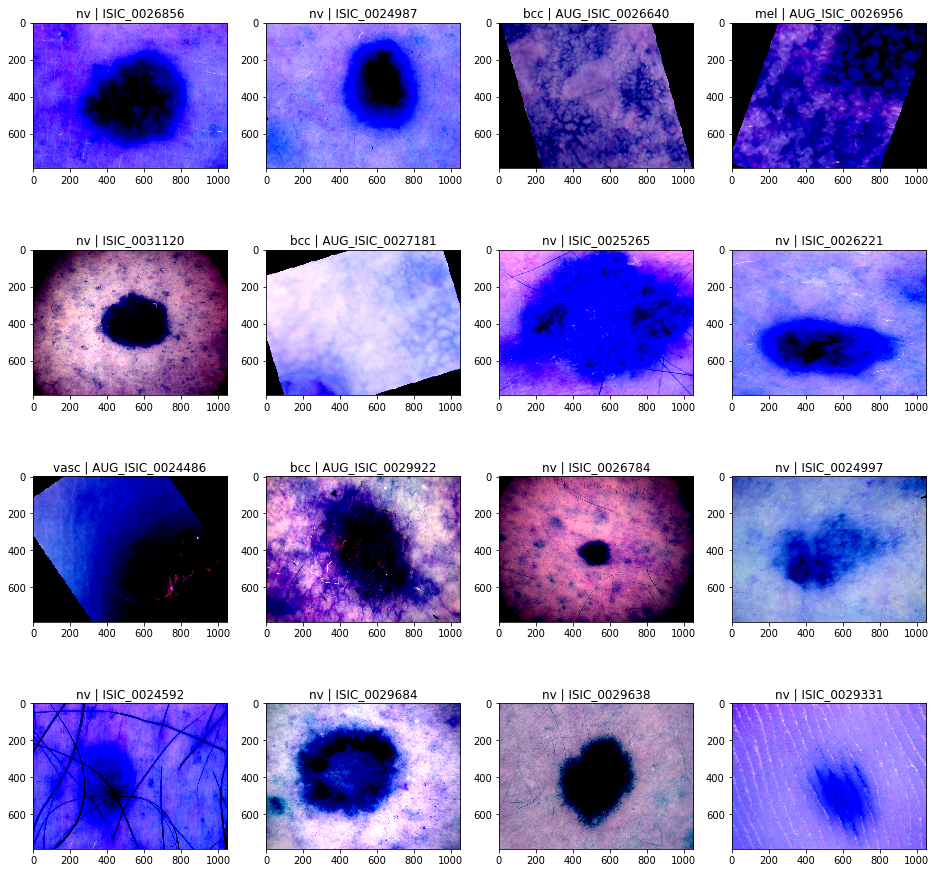

In [20]:
fig, axarr = plt.subplots(4, 4)

fig_size = 16

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

for ax, ind in zip(axarr.flatten(), index_subsample):
    # Getting the image:
    image = train_set[ind][0]
    # Converting the image to numpy and applying transpose on its
    # dimension so it can be plotted by matplotlib:
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    # Getting the image label and id:
    label = train_set[ind][2]
    im_id = train_set[ind][3]
    title = f'{label} | {im_id}'
    
    ax.set_title(title)
    ax.imshow(image)

### Creating the DataLoader objects:

In [21]:
train_batch_size, validation_batch_size, test_batch_size = 32, 32, 32

# Setting the num_workers to the number of cores on this machine.
num_workers = 6

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

### Creating the model:

In [22]:
dropout_prob = [0.5, 0.5, 0.5]

In [23]:
model = Model(dropout_prob=dropout_prob, num_classes=dataset.num_classes, image_dim=image_dim)

### Defining the optimizer, criterion, and hyperparameters:

In [24]:
learning_rate = 1e-3
weight_decay = 1e-5

# --- Defining the optimizer: ---------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Defining the learning rate schedular:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6], gamma=0.1)
scheduler = None
 
# --- Defining the loss function: -----------------------------------------------------
criterion = nn.CrossEntropyLoss()

### Defining the number of epochs:

In [25]:
epochs = 10

# Training the model

In [26]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating epoch...


 10%|█         | 1/10 [15:31<2:19:47, 931.92s/it]

Epoch: 0 | Train_acc: 30.61% | Val_acc: 66.93% | Loss: 2447.15 | Runtime: 931.92 seconds
Evaluating epoch...


 20%|██        | 2/10 [31:14<2:05:03, 937.99s/it]

Epoch: 1 | Train_acc: 37.56% | Val_acc: 64.60% | Loss: 1622.54 | Runtime: 942.24 seconds
Evaluating epoch...


 30%|███       | 3/10 [47:24<1:51:08, 952.71s/it]

Epoch: 2 | Train_acc: 38.29% | Val_acc: 67.73% | Loss: 1563.60 | Runtime: 970.22 seconds
Evaluating epoch...


 40%|████      | 4/10 [1:03:45<1:36:24, 964.05s/it]

Epoch: 3 | Train_acc: 40.95% | Val_acc: 68.93% | Loss: 1519.22 | Runtime: 981.45 seconds


 40%|████      | 4/10 [1:09:21<1:44:02, 1040.49s/it]


KeyboardInterrupt: 

## Plotting the train and validation accuracies:

In [ ]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.plot(accuracies_validation, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

## Plotting the loss:

In [ ]:
figure(figsize=(10, 4), dpi=80)

plt.title('Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss Value")

plt.plot(total_loss, 'go-')
plt.show()

# Evaluating the model with the test set:

In [ ]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [ ]:
print(f'Test accuracy: {test_accuracy:.2f}%')

# Class Accuracies

In [ ]:
nb_classes = 7
preds_list = []
confusion_mat = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes, _, _) in tqdm(enumerate(test_loader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for item in preds:
            preds_list.append(item.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_mat[t.long(), p.long()] += 1

In [ ]:
classes = np.unique(test_set.labels)

class_accuracies = confusion_mat.diag()/confusion_mat.sum(1)
class_acc_dict = dict(zip(classes, class_accuracies.tolist()))

for cls, accuracy in class_acc_dict.items():
    print(f'{cls}: {100 * accuracy:.2f}%')

In [ ]:
ground_truth = test_set.mapped_labels

In [ ]:
preds_list = np.array(preds_list)

### Printing the confusion matrix:

In [ ]:
conf_mat = confusion_matrix(ground_truth, preds_list)

In [ ]:
print(conf_mat)

### Testing the model with precision, recall, and f1-score:

In [ ]:
print(classification_report(ground_truth, preds_list))

# Saving the model:

### Creating the path in which the model will be saved:

In [ ]:
path = os.getcwd()
model_name = f'skin_cancer_model_v2'

In [ ]:
MODEL_PATH = os.path.join(path, model_name)

### Saving the model:

In [ ]:
# torch.save(model.state_dict(), MODEL_PATH)